# Khám phá mối quan hệ trong dữ liệu

## Import các thư viện cần thiết

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import pacf, acf

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)

## Đọc dữ liệu từ file csv vào dataframe

In [2]:
data = pd.read_csv("../datasets/data_preprocess.csv", index_col = 0)
data.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


In [3]:
data['date'] = pd.to_datetime(data['date'])
data[['film_code', 'cinema_code']] = data[['film_code', 'cinema_code']].astype(str)

## Doanh thu của các rạp chiếu phim như thế nào theo thời gian?

In [4]:
print('Dữ liệu tính từ ngày', data['date'].dt.date.min(), 'đến ngày', data['date'].dt.date.max())

Dữ liệu tính từ ngày 2018-02-21 đến ngày 2018-11-04


Ta thử xem xem tổng doanh thu của các rạp phim theo từng ngày có gì đặc biệt không nhé

In [5]:
temp = data.groupby(['date']).agg({'total_sales': ['sum']}).sort_index().reset_index()
temp.columns = ['date', 'total_sales'] #, 'mean_sales']

Khi in dữ liệu ra ta có thể thấy dữ liệu không liên tục, có nhiều ngày không có dữ liệu. Vì thế mà dữ liệu nên được biểu diễn bằng scatter do nếu biểu diễn bằng biểu đồ đường thì sẽ tạo ra thêm những thông tin sai lầm, ví dụ như có dữ liệu 21 và 23 nhưng không có dữ liệu ngày 22, nếu vẽ biểu đồ đường thì người xem sẽ hiểu giá trị ngày 22 là lấy đoạn giữa 21 23 chiếu lên trục y, như vậy là không đúng.

Text(0.5, 1.0, 'tổng doanh thu của các rạp phim theo ngày')

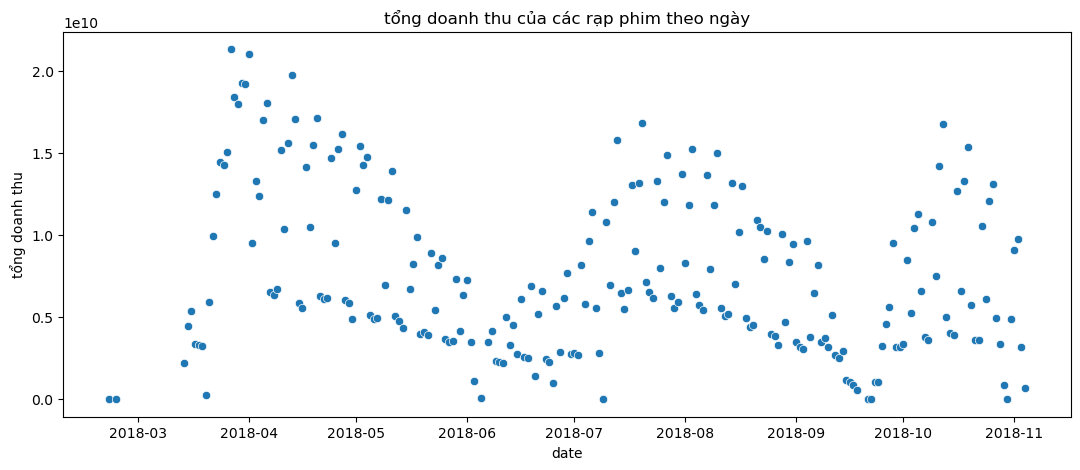

In [6]:
plt.figure(figsize = (13, 5))
sns.scatterplot(data = temp, x = 'date', y = 'total_sales')
plt.ylabel('tổng doanh thu')
plt.title('tổng doanh thu của các rạp phim theo ngày')

Text(0.5, 1.0, 'tổng doanh thu của các rạp phim theo ngày')

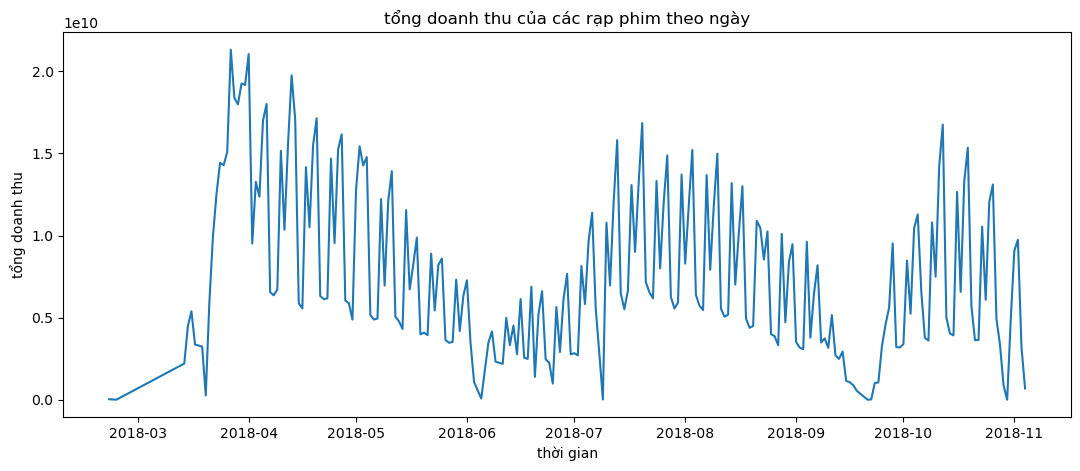

In [7]:
plt.figure(figsize = (13, 5))
sns.lineplot(data = temp, x = 'date', y = 'total_sales')
plt.xlabel('thời gian')
plt.ylabel('tổng doanh thu')
plt.title('tổng doanh thu của các rạp phim theo ngày')

Text(0.5, 1.0, 'Tổng doanh thu của các rạp phim theo ngày làm mịn với window = 15')

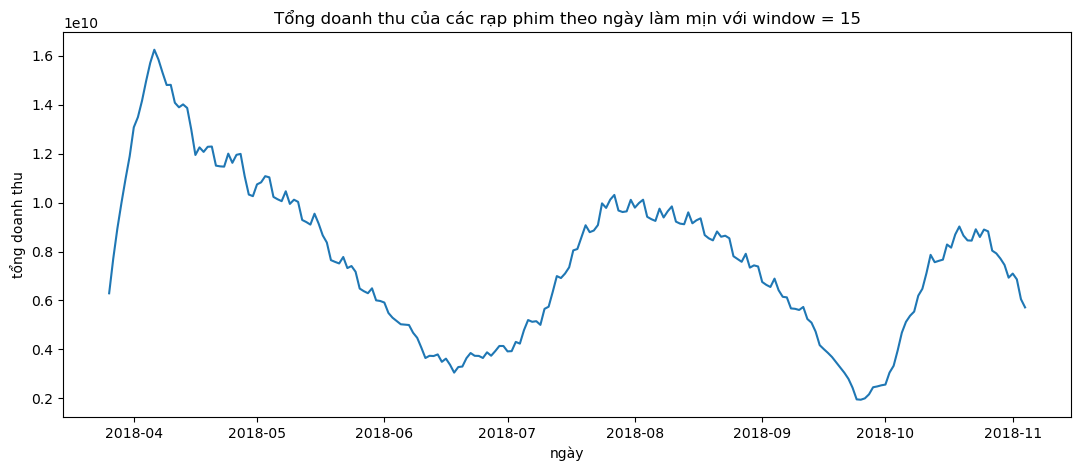

In [8]:
temp_data = temp.copy()
temp_data['smooth'] = temp['total_sales'].rolling(window = 15).mean()
plt.figure(figsize = (13, 5))
sns.lineplot(data = temp_data, x = 'date', y = 'smooth')
plt.xlabel('ngày')
plt.ylabel('tổng doanh thu')
plt.title('Tổng doanh thu của các rạp phim theo ngày làm mịn với window = 15')

Text(0.5, 1.0, 'Biểu đồ tổng doanh thu của các rạp phim đã làm mịn với window = 15 và loại bỏ xu hướng')

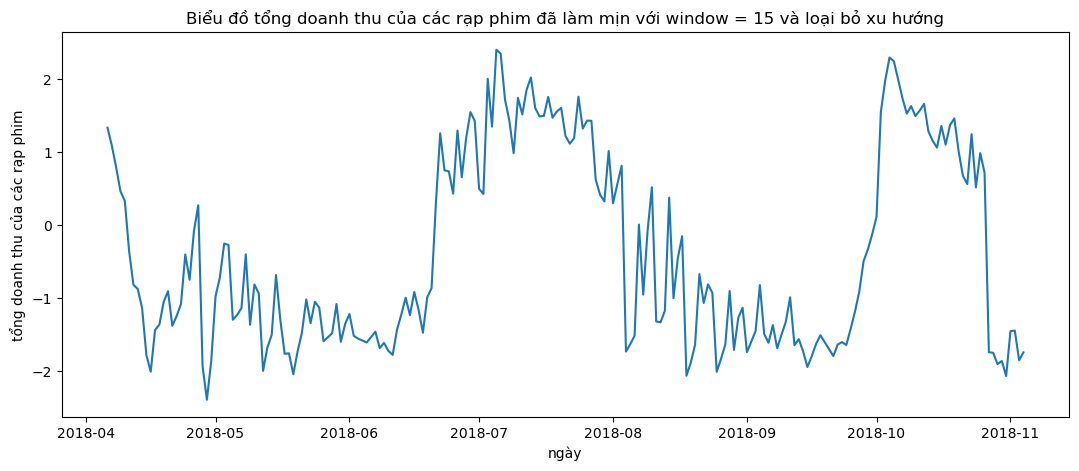

In [9]:
temp_detrend = (temp_data['smooth'] - temp_data['smooth'].rolling(window=12).mean()) / temp_data['smooth'].rolling(window=12).std()
# temp_detrend = (temp['total_sales'] - temp['total_sales'].rolling(window=12).mean()) / temp['total_sales'].rolling(window=12).std()

temp_detrend.index = temp['date']
plt.figure(figsize = (13, 5))
sns.lineplot(data = temp_detrend)
plt.xlabel('ngày')
plt.ylabel('tổng doanh thu của các rạp phim')
plt.title('Biểu đồ tổng doanh thu của các rạp phim đã làm mịn với window = 15 và loại bỏ xu hướng')

In [10]:
train = pd.DataFrame(index = temp['date'], data = temp['total_sales'].values, columns = ['total_sales'])

In [11]:
fill_data = pd.DataFrame(index = ['total_sales'])
i = train.index[0]
while i < train.index[-1]:
    if i not in train.index:
        prev = i - pd.DateOffset(days=1)
        while prev not in train.index:
            prev = prev - pd.DateOffset(days=1)
        next_ = i + pd.DateOffset(days=1)
        while next_ not in train.index:
            next_ = next_ + pd.DateOffset(days=1)
        
        val = (train.loc[prev][0] * (next_ - i).days + train.loc[next_][0] * (i - prev).days) / (next_ - prev).days
        fill_data[i.strftime('%Y-%m-%d')] = round(val)
    i += pd.DateOffset(days=1)
fill_data = fill_data.T
train = pd.concat([train, fill_data])
train.index = pd.to_datetime(train.index)
train = train.sort_index()

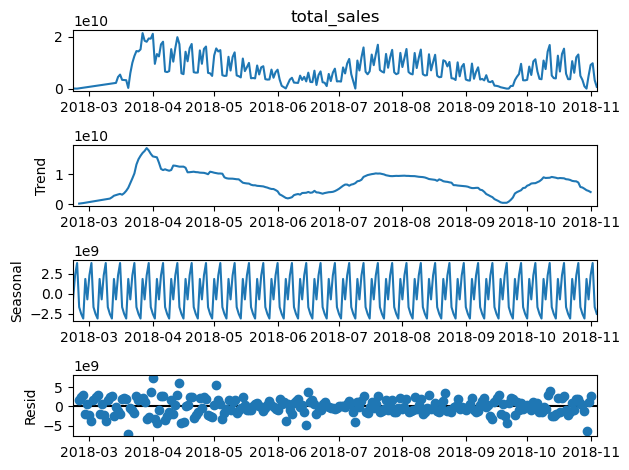

In [12]:
result = seasonal_decompose(train['total_sales'], model='additive')
result.plot()
plt.show()

In [13]:
seasonal = result.seasonal
f = seasonal[seasonal.values == seasonal.max()]
f = (f.index[1] - f.index[0]).days
print(f'Theo như mô hình, dữ liệu có tính chu kỳ với độ dài là {f} ngày')

Theo như mô hình, dữ liệu có tính chu kỳ với độ dài là 7 ngày


<AxesSubplot:ylabel='resid'>

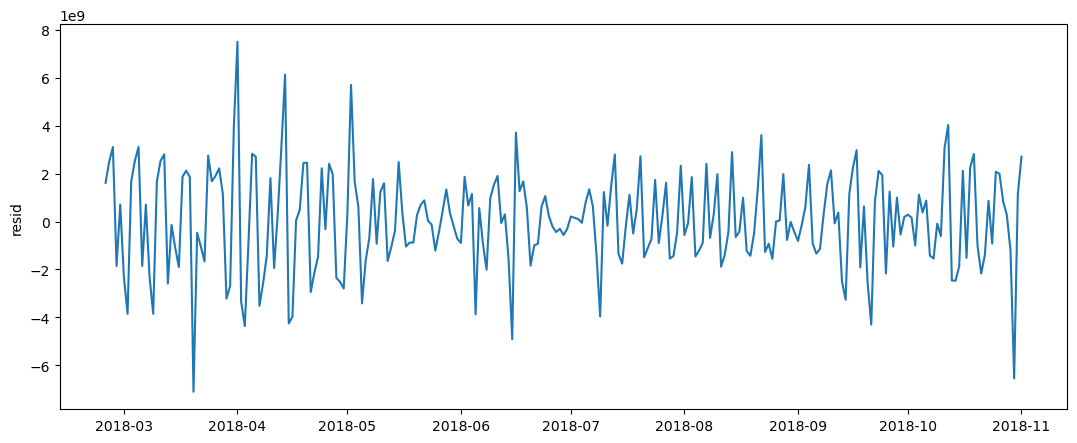

In [14]:
plt.figure(figsize = (13, 5))
sns.lineplot(data = result.resid)

In [15]:
# Tính toán PACF
pacf_values = pacf(train)

# Xác định số lags dựa trên giá trị tương quan riêng biệt đáng chú ý
p_lags = 0
for i, pacf_value in enumerate(pacf_values):
    if abs(pacf_value) < 1.96/np.sqrt(len(train)):
        p_lags = i
        break

# Số lags xác định
print("Số p_lags xác định:", p_lags)

# Tính toán ACF
acf_values = acf(train)

# Xác định số lags dựa trên giá trị tương quan riêng biệt đáng chú ý
lags = 0
for i, acf_value in enumerate(acf_values):
    if abs(acf_value) < 1.96/np.sqrt(len(train)):
        lags = i
        break

# Số lags xác định
print("Số lags xác định:", lags)

Số p_lags xác định: 2
Số lags xác định: 16


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36405D+01    |proj g|=  1.08248D+00


 This problem is unconstrained.



At iterate    5    f=  2.31456D+01    |proj g|=  4.79101D-02

At iterate   10    f=  2.31181D+01    |proj g|=  5.38860D-02

At iterate   15    f=  2.31116D+01    |proj g|=  2.51110D-02

At iterate   20    f=  2.31087D+01    |proj g|=  1.39099D-02

At iterate   25    f=  2.31055D+01    |proj g|=  1.09936D-02

At iterate   30    f=  2.31041D+01    |proj g|=  9.42468D-03

At iterate   35    f=  2.31033D+01    |proj g|=  1.43977D-02

At iterate   40    f=  2.31024D+01    |proj g|=  4.42101D-03

At iterate   45    f=  2.31020D+01    |proj g|=  4.41262D-03

At iterate   50    f=  2.31011D+01    |proj g|=  2.74556D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

Text(0.5, 1, 'Mô hình dự đoán doanh thu trong 20 ngày tiếp theo bằng SARIMA')

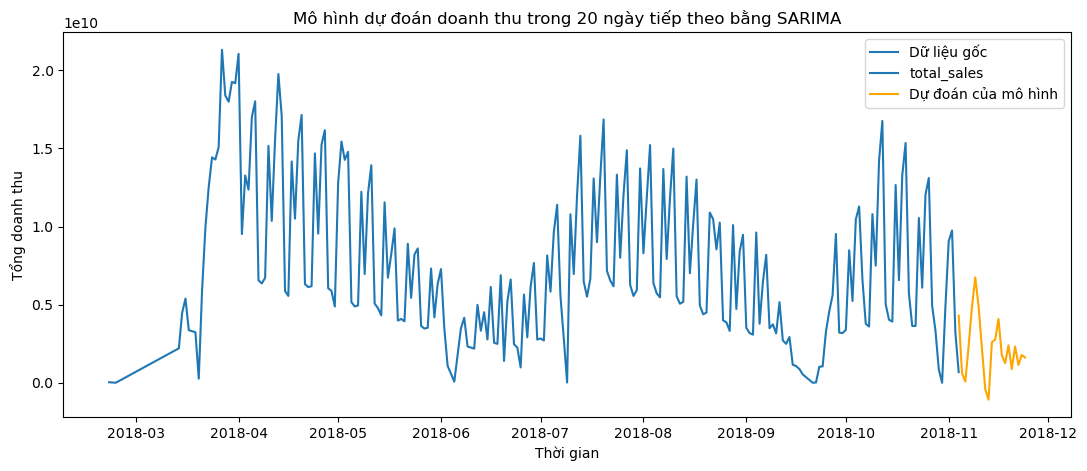

In [16]:
model = SARIMAX(train['total_sales'], order=(2, 2, 16))
model_fit = model.fit()
predictions = model_fit.predict(start = train.index[-1], end = train.index[-1] + pd.DateOffset(days = 20))

plt.figure(figsize = (13, 5))
sns.lineplot(data = train, label = 'Dữ liệu gốc', color = 'blue')
sns.lineplot(data = predictions, label = 'Dự đoán của mô hình', color = 'orange')
plt.xlabel('Thời gian')
plt.ylabel('Tổng doanh thu')
plt.title('Mô hình dự đoán doanh thu trong 20 ngày tiếp theo bằng SARIMA', y = 1)

In [17]:
trend = result.trend.dropna()
trend = pd.DataFrame(index = trend.index, data = trend.values, columns = ['total_sales'])

In [18]:
# Tính toán PACF
pacf_values = pacf(trend)

# Xác định số lags dựa trên giá trị tương quan riêng biệt đáng chú ý
p_lags = 0
for i, pacf_value in enumerate(pacf_values):
    if abs(pacf_value) < 1.96/np.sqrt(len(trend)):
        p_lags = i
        break

# Số lags xác định
print("Số lags xác định:", p_lags)

Số lags xác định: 6


In [19]:
# Tính toán ACF
acf_values = acf(trend)

# Xác định số lags dựa trên giá trị tương quan riêng biệt đáng chú ý
lags = 0
for i, acf_value in enumerate(acf_values):
    if abs(acf_value) < 1.96/np.sqrt(len(trend)):
        lags = i
        break

# Số lags xác định
print("Số lags xác định:", lags)

Số lags xác định: 20


Text(0.5, 1, 'Mô hình dự đoán doanh thu trong 90 ngày tiếp theo bằng SARIMA')

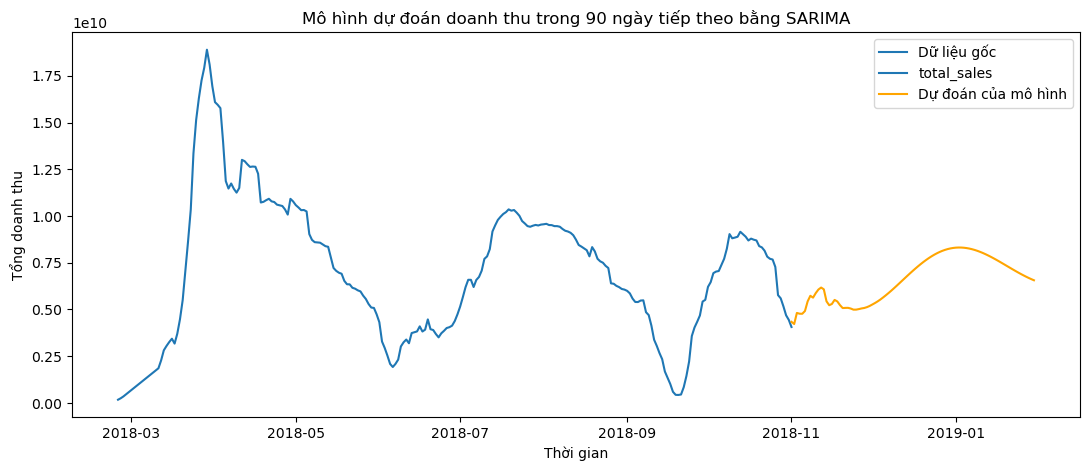

In [20]:
model = ARIMA(trend['total_sales'], order=(6, 0, 20))
model_fit = model.fit()
predictions = model_fit.predict(start = trend.index[-1], end = trend.index[-1] + pd.DateOffset(days = 90))

plt.figure(figsize = (13, 5))
sns.lineplot(data = trend, label = 'Dữ liệu gốc', color = 'blue')
sns.lineplot(data = predictions, label = 'Dự đoán của mô hình', color = 'orange')
plt.xlabel('Thời gian')
plt.ylabel('Tổng doanh thu')
plt.title('Mô hình dự đoán doanh thu trong 90 ngày tiếp theo bằng SARIMA', y = 1)